# Link to World Bank Dataset Overview
https://financesone.worldbank.org/api-explorer?id=DS00975

# 📘 Loan Cancellation and Disbursement Behavior Prediction

## Problem Statement
The goal of this project is to predict loan cancellation and disbursement outcomes as indicators of a country’s ability to repay its loans.

## Topic
**Loan Cancellation and Disbursement Behavior Prediction**

---

## Phase 1: Data Acquisition
- [x] Create public repositroy through GitHub  
- [x] Connect Open Source World Bank dataset to Jupyter Notebook via World Bank API
- [x] Implement partial downloading of data to save progress and prevent system throttling 
- [x] Progress bar to track download of data
- [x] Store Data in .parquet file for compression and easy read

---

## Phase 2: Data Preparation

- [ ] Clean dataset and remove irrelevant columns  
- [ ] Impute missing values using a pretrained model
- [x] One Hot Encode Categorical Variables
- [x] Use scalar on loan amount 
- [ ] Mask sensitive data using models
- [x] Feature Engineering    
- [x] Combine Multiple datasets from various sources

---

## Phase 3: Model Implementation
- [ ] Implement machine learning models to predict loan disbursement and cancellation behavior 
- [ ] Implement hugging face tabular transformer based model
- [ ] Evaluate performance using appropriate metrics (accuracy, F1-score, ROC-AUC)  
- [ ] Compare baseline models vs. advanced models (e.g., Hugging Face TabTransformer) 
- [ ] Fine tune variables preventing Feature leakage and model cheating
- [ ] HyperParameter Tuning for optimal accuracy

---

## Phase 4: Model Deployment
- [ ] Deploy the trained model using **Hugging Face Spaces** or **Azure Machine Learning**  
- [ ] Create a simple web-based interface for predictions and visual insights  

---

## Phase 5: Dataset Expansion
- [ ] Merge an additional dataset (e.g., GDP data)  
- [ ] Join using the **World Bank Country Code**  
- [ ] Analyze the impact of macroeconomic indicators on loan outcomes  

---

## Challenges and Things to Consider:

- [ ] Countries Changing Yugoslavia → Serbia , Zaire → DR Congo
- [ ] Payment distribution more than loan because of inflation  
- [ ] Extremely Messy inconsistent data to be used with caution and careful finetuning


## 📈 Additional Topics to Explore
- **Loan Default Risk Prediction**  
- **Loan Repayment Time Forecasting**  
- **Regional Loan Portfolio Performance Analysis**
- **CI/CD With Versioning**
- **Containerzation**
- **Local Flask API Endpoint For Interaction**
- **Bronze/Silver/Gold Best Practice Data Storage SQLlite**
---

## Objective Summary
This project aims to build an interpretable AI model capable of predicting loan cancellation and disbursement behavior using historical World Bank data, regional attributes, and macroeconomic indicators. The findings will help assess each country’s ability to fulfill its loan obligations and guide data-driven lending decisions.


In [ ]:
import requests, json, time, os
from tqdm import tqdm

def fetch_all_data():
    base_url = "https://datacatalogapi.worldbank.org/dexapps/fone/api/apiservice"
    dataset_id = "DS00975"
    resource_id = "RS00905"
    top = 1000
    page = 1
    all_data = []

    # 🔁 Resume if a partial file already exists
    if os.path.exists("worldbank_partial.json"):
        with open("worldbank_partial.json") as f:
            all_data = json.load(f)
        page = len(all_data)//top + 1
        print(f"Resuming from page {page} ({len(all_data):,} records already saved)")

    with tqdm(total=1472089, desc="Downloading rows", unit="rows") as pbar:
        pbar.update(len(all_data))
        while True:
            url = f"{base_url}?datasetId={dataset_id}&resourceId={resource_id}&top={top}&type=json&skip={1000*(page-1)}"
            try:
                r = requests.get(url, timeout=20)
                r.raise_for_status()
                data = r.json()
                if "data" not in data or not data["data"]:
                    break
                all_data.extend(data["data"])
                pbar.update(len(data["data"]))

                if page % 10 == 0:
                    with open("worldbank_partial.json", "w") as f:
                        json.dump(all_data, f)
                    print(f"Saved checkpoint at page {page} ({len(all_data):,} rows)")
                page += 1
                time.sleep(0.2)
            except requests.RequestException as e:
                print(f"Error on page {page}: {e}. Retrying in 10s.")
                time.sleep(10)
                continue

    # Final save
    with open("worldbank_loans_full.json", "w") as f:
        json.dump(all_data, f)
    print(f"\n✅ Download complete — {len(all_data):,} records saved.")
    return all_data

if __name__ == "__main__":
    all_data = fetch_all_data()


In [ ]:
import pandas as pd
df = pd.read_json("worldbank_loans_full.json")
df.to_parquet("worldbank_loans.parquet")


In [1]:
# ==============================================
# 📊 DATA LOADING AND INITIAL SETUP
# ==============================================
# Load the main World Bank loans dataset
import pandas as pd
df = pd.read_parquet("worldbank_loans.parquet")

# Load additional GDP datasets for feature enrichment
gdp_total = pd.read_csv("gdp_total.csv")
gdp_per_capita = pd.read_csv("gdp_per_capita.csv")

# Merge GDP datasets on Country and Year
# Using 'outer' join to preserve all records from both datasets
# This ensures we don't lose any country-year combinations
gdp = gdp_total.merge(
    gdp_per_capita,
    on=["Country", "Year"],
    how="outer",  # use "outer" so you keep rows that appear in only one file
    suffixes=("_total", "_per_capita")
)

# Save combined GDP data for future use
gdp.to_csv("gdp_combined.csv", index=False)

print(f"✅ Loaded {len(df):,} loan records")
print(f"✅ Loaded {len(gdp_total):,} GDP total records")
print(f"✅ Loaded {len(gdp_per_capita):,} GDP per capita records")
print(f"✅ Combined GDP data: {len(gdp):,} records")


✅ Loaded 1,472,089 loan records
✅ Loaded 17,290 GDP total records
✅ Loaded 17,290 GDP per capita records
✅ Combined GDP data: 17,290 records


In [2]:
# ==============================================
# 🌍 COUNTRY CODE STANDARDIZATION
# ==============================================
# Convert ISO3 country codes to ISO2 format for consistency with loans data
import pycountry

# Step 1: Filter to only valid ISO3 countries (exclude regional aggregations)
valid_iso3 = {c.alpha_3 for c in pycountry.countries}
gdp = gdp[gdp["Country"].isin(valid_iso3) | gdp["Country"].eq("XKX")]

# Step 2: Map ISO3 to ISO2 codes
iso3_to_iso2 = {c.alpha_3: c.alpha_2 for c in pycountry.countries}
gdp["country_code"] = gdp["Country"].map(iso3_to_iso2)

# Step 3: Apply manual fixes for historical/country name changes
# (Important for handling data spanning multiple decades)
manual_fixes = {
    "XKX": "XK",   # Kosovo (World Bank pseudo-ISO)
    "SRB": "YU",   # Yugoslavia → Serbia (officially split; use RS)
    "SCG": "RS",   # Serbia and Montenegro → Serbia
    "TLS": "TL",   # Timor-Leste (old code TMP / TP → TL)
    "COD": "ZR",   # Zaire → DR Congo
    "TWN": "TW",   # Taiwan (ISO-3 = TWN → ISO-2 = TW)
}

# Apply manual fixes safely
gdp["country_code"] = gdp.apply(
    lambda row: manual_fixes.get(row["Country"], row["country_code"]),
    axis=1
)

print(f"✅ Standardized country codes for {gdp['country_code'].nunique()} countries")


✅ Standardized country codes for 216 countries


In [3]:
# ==============================================
# 🧹 CLEANING COUNTRY CODES IN LOANS DATA
# ==============================================
# Apply the same country code standardizations to loans data

# Step 1: Fix historical country code changes
df["country_code"] = df["country_code"].replace("YF", "YU")  # Yugoslavia fix
df["country_code"] = df["country_code"].replace("TP", "TL")  # Timor-Leste fix

# Step 2: Define invalid/regional codes to remove
# These codes represent regional aggregations, not individual countries
invalid_codes = {None, "3W", "3E", "3S", "6R", "TW"}

# Store original count before filtering
original_count = len(df)

# Step 3: Remove rows with invalid country codes
df = df[~df["country_code"].isin(invalid_codes)].copy()

# Step 4: Verification
removed_count = original_count - len(df)
print(f"✅ Removed {removed_count:,} rows with invalid country codes")
print(f"✅ Unique countries after cleanup: {df['country_code'].nunique()}")
print(f"✅ Remaining records: {len(df):,}")



✅ Removed 7,208 rows with invalid country codes
✅ Unique countries after cleanup: 141
✅ Remaining records: 1,464,881


In [4]:
# Get unique country codes from both DataFrames
df_codes = set(df["country_code"].dropna().unique())
gdp_codes = set(gdp["country_code"].dropna().unique())

# 1️⃣ Codes in df but not in gdp
missing_from_gdp = df_codes - gdp_codes

# 2️⃣ Codes in gdp but not in df
missing_from_df = gdp_codes - df_codes

print("🚫 In df but missing from gdp:", missing_from_gdp)

🚫 In df but missing from gdp: set()


## Feature Selection and Data Cleaning Before Merge

Before merging with GDP data, we should:
1. Remove highly redundant columns
2. Remove columns with excessive missing data
3. Keep only features relevant for loan cancellation/disbursement prediction


# 📊 Exploratory Data Analysis & Visualizations


In [ ]:
# Exploratory Data Analysis Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# 1. Loan Outcome Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
if 'loan_outcome' in df.columns:
    outcome_counts = df['loan_outcome'].value_counts()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    plt.pie(outcome_counts.values, labels=outcome_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('Loan Outcome Distribution', fontsize=12, fontweight='bold')

# 2. Interest Rate Distribution
plt.subplot(1, 3, 2)
if 'interest_rate' in df.columns:
    df_plot = df[df['interest_rate'].notna() & (df['interest_rate'] > 0)]
    plt.hist(df_plot['interest_rate'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Interest Rate (%)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title('Interest Rate Distribution', fontsize=12, fontweight='bold')
    plt.axvline(df_plot['interest_rate'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_plot["interest_rate"].mean():.2f}')
    plt.legend()

# 3. Principal Amount Distribution (log scale)
plt.subplot(1, 3, 3)
if 'original_principal_amount' in df.columns:
    df_plot = df[df['original_principal_amount'].notna() & (df['original_principal_amount'] > 0)]
    plt.hist(np.log1p(df_plot['original_principal_amount']), bins=50, 
             color='darkgreen', alpha=0.7, edgecolor='black')
    plt.xlabel('Log(Principal Amount + 1)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title('Principal Amount Distribution\n(Log Scale)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Regional Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
if 'region' in df.columns:
    region_counts = df['region'].value_counts().head(10)
    plt.barh(range(len(region_counts)), region_counts.values, color='coral')
    plt.yticks(range(len(region_counts)), region_counts.index)
    plt.xlabel('Count', fontsize=10)
    plt.title('Top 10 Regions by Loan Count', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()

# 5. Loan Type Distribution
plt.subplot(1, 2, 2)
if 'loan_type' in df.columns:
    loan_type_counts = df['loan_type'].value_counts().head(10)
    plt.barh(range(len(loan_type_counts)), loan_type_counts.values, color='mediumpurple')
    plt.yticks(range(len(loan_type_counts)), loan_type_counts.index)
    plt.xlabel('Count', fontsize=10)
    plt.title('Top 10 Loan Types', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# 6. GDP Metrics Over Time (if available)
if 'gdp_total' in df.columns and 'Year' in df.columns:
    plt.figure(figsize=(12, 5))
    
    # Calculate average GDP per year
    gdp_yearly = df.groupby('Year')[['gdp_total', 'gdp_per_capita']].mean()
    
    plt.subplot(1, 2, 1)
    plt.plot(gdp_yearly.index, gdp_yearly['gdp_total'], marker='o', linewidth=2, color='steelblue')
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Avg GDP Total', fontsize=10)
    plt.title('Average GDP Total Over Time', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(gdp_yearly.index, gdp_yearly['gdp_per_capita'], marker='s', linewidth=2, color='darkgreen')
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Avg GDP Per Capita', fontsize=10)
    plt.title('Average GDP Per Capita Over Time', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Exploratory Data Analysis complete!")


In [5]:
# ==============================================
# 📋 COLUMN SELECTION AND CLEANING BEFORE MERGE
# ==============================================
# Analyze column completeness and select relevant features

# Calculate missing data percentage for each column
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Column Missing Data Analysis:\n")
print(missing_pct.head(15))

# Define columns to drop before merging:
# 1. Columns with >80% missing data (not informative)
# 2. Highly redundant columns
# 3. Internal IDs not useful for modeling

high_missing_cols = missing_pct[missing_pct > 80].index.tolist()
redundant_cols = [
    "currency_of_commitment",  # Mostly missing, redundant with loan details
    "project_id",              # Internal ID, not predictive
]

# Select key features to keep for analysis
features_to_keep = [
    # Core identifiers
    "loan_number",
    "country",
    "country_code",
    "region",
    
    # Loan financials (targets for prediction)
    "original_principal_amount",
    "disbursed_amount",
    "cancelled_amount",
    
    # Loan terms and characteristics
    "loan_type",
    "loan_status",
    "interest_rate",
    "borrowers_obligation",
    "due_to_ibrd",
    "loans_held",
    
    # Dates (for creating time features)
    "board_approval_date",
    "end_of_period",
    
    # Additional context
    "project_name_",
    "borrower",
]

print(f"\n📊 Columns with >80% missing: {len(high_missing_cols)}")
print(f"🗑️  Redundant columns to remove: {redundant_cols}")

# Create cleaned dataframe with selected features
df_clean = df[features_to_keep].copy()
print(f"\n✅ Cleaned dataset: {len(df_clean):,} rows × {len(df_clean.columns)} columns")


Column Missing Data Analysis:

currency_of_commitment        95.562302
last_disbursement_date        40.369696
project_name_                 10.824702
guarantor                      5.289099
guarantor_country_code         3.474958
interest_rate                  2.206596
agreement_signing_date         1.484489
effective_date_most_recent     0.813445
borrower                       0.684970
first_repayment_date           0.321801
last_repayment_date            0.321255
closed_date_most_recent        0.094069
project_id                     0.002867
board_approval_date            0.000137
country                        0.000000
dtype: float64

📊 Columns with >80% missing: 1
🗑️  Redundant columns to remove: ['currency_of_commitment', 'project_id']

✅ Cleaned dataset: 1,464,881 rows × 17 columns


In [6]:
# ==============================================
# 📅 CREATE TIME-BASED FEATURES FOR MERGING
# ==============================================
# Extract year from board_approval_date to enable time-based merging with GDP data
# This allows us to match each loan's approval year with corresponding GDP data

df_clean["Year"] = pd.to_datetime(df_clean["board_approval_date"], errors="coerce").dt.year

# Check year range for validation
print(f"📅 Loan years range from {df_clean['Year'].min()} to {df_clean['Year'].max()}")
print(f"📊 {df_clean['Year'].isna().sum():,} loans without valid approval date")


📅 Loan years range from 1947.0 to 2025.0
📊 1,251,741 loans without valid approval date


In [7]:
df[["board_approval_date", "agreement_signing_date"]].head(5)

,board_approval_date,agreement_signing_date
0,09-May-1947,09-May-1947
1,09-May-1947,09-May-1947
2,09-May-1947,09-May-1947
3,09-May-1947,09-May-1947
4,09-May-1947,09-May-1947


In [8]:
# ==============================================
# 🔗 MERGE LOANS DATA WITH GDP DATA
# ==============================================
# Combine loan records with corresponding GDP data by country and year
# Using left join to preserve all loan records even if GDP data is missing

print(f"Before merge: {len(df_clean):,} loan records")

# Perform the merge
df_merged = pd.merge(
    df_clean,
    gdp,
    how="left",
    on=["country_code", "Year"],
    indicator=True  # Track which records matched
)

# Check merge quality
print(f"After merge: {len(df_merged):,} records")
print(f"\n📊 Merge Statistics:")
print(df_merged["_merge"].value_counts())

# Check for missing GDP data
missing_gdp = df_merged["_merge"] == "left_only"
print(f"\n⚠️  Loans without matching GDP data: {missing_gdp.sum():,} ({missing_gdp.sum()/len(df_merged)*100:.2f}%)")

# Drop merge indicator column
df = df_merged.drop(columns=["_merge", "Country"]).copy()

print(f"\n✅ Final merged dataset: {len(df):,} rows")




Before merge: 1,464,881 loan records
After merge: 1,464,881 records

📊 Merge Statistics:
_merge
left_only     1255492
both           209389
right_only          0
Name: count, dtype: int64

⚠️  Loans without matching GDP data: 1,255,492 (85.71%)

✅ Final merged dataset: 1,464,881 rows


In [9]:
min_non_missing = 5   # require at least 5 real data points per country
country_counts = gdp[gdp.columns].notna().groupby(gdp["country_code"]).sum()
keep = country_counts[(country_counts["gdp_total"] >= min_non_missing) | 
                      (country_counts["gdp_per_capita"] >= min_non_missing)].index
gdp = gdp[gdp["country_code"].isin(keep)]


In [10]:
# =============================================
# 🧩 1️⃣  Install required libraries (if needed)
# =============================================
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install pypots pandas numpy matplotlib tqdm

# =============================================
# 🧩 2️⃣  Import dependencies
# =============================================
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from pypots.imputation.saits import SAITS
from sklearn.preprocessing import StandardScaler

# =============================================
# 🧩 3️⃣  Load and preprocess GDP data
# =============================================

# ✅ convert blank cells to NaN
gdp = gdp.replace(r"^\s*$", np.nan, regex=True)

# ✅ ensure numeric, force bad values to NaN
features = ["gdp_total", "gdp_per_capita"]
gdp[features] = gdp[features].apply(pd.to_numeric, errors="coerce")

# ✅ sort dataset
gdp = gdp.sort_values(["country_code", "Year"])

countries = gdp["country_code"].unique()
years = sorted(gdp["Year"].unique())
n_countries = len(countries)
n_years = len(years)
n_features = len(features)

# ✅ build full panel (outer join ensures every country×year exists)
panel = (
    pd.MultiIndex.from_product([countries, years], names=["country_code", "Year"])
    .to_frame(index=False)
    .merge(gdp, on=["country_code", "Year"], how="left")
    .sort_values(["country_code", "Year"])
)

# =============================================
# 🧩 4️⃣  Normalize per-country IN LOG SPACE
# =============================================
scalers = {}
panel_scaled = pd.DataFrame()

for c in countries:
    sub = panel[panel["country_code"] == c].copy()

    # log1p transform (keeps positive domain and stabilizes variance)
    sub_log = np.log1p(sub[features])

    scaler = StandardScaler()
    sub[features] = scaler.fit_transform(sub_log)

    scalers[c] = scaler
    panel_scaled = pd.concat([panel_scaled, sub], ignore_index=True)

panel = panel_scaled.copy()

# =============================================
# 🧩 5️⃣  Build 3D tensor (countries × years × features)
# =============================================
print("Missing BEFORE tensor:", gdp[features].isna().sum().to_dict())

data = np.full((n_countries, n_years, n_features), np.nan, dtype=np.float32)

for i, c in enumerate(countries):
    sub = panel[panel["country_code"] == c]
    for j, y in enumerate(years):
        row = sub[sub["Year"] == y]
        if not row.empty:
            data[i, j, 0] = row["gdp_total"].values[0]
            data[i, j, 1] = row["gdp_per_capita"].values[0]

print("Missing INSIDE tensor:", np.isnan(data).sum())
print(f"📊 Data shape: {data.shape}")

# =============================================
# 🧩 6️⃣  Build SAITS training dict with mask
# =============================================
mask = ~np.isnan(data)
train_dict = {"X": data, "missing_mask": mask}

# =============================================
# 🧩 7️⃣  Train SAITS properly
# =============================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n💻 Using device: {device}")

model = SAITS(
    n_steps=n_years,
    n_features=n_features,
    n_layers=2,
    d_model=64,
    d_ffn=128,
    n_heads=4,
    d_k=32,
    d_v=32,
    dropout=0.1,
    epochs=100,
    batch_size=16,
    device=device,
)

print("\n🚀 Training SAITS model...")
model.fit(train_dict)
print("✅ Training complete!")

# =============================================
# 🧩 8️⃣  Impute missing values
# =============================================
print("\n💡 Imputing missing GDP values...")
imputed = model.impute(train_dict)
print("✅ Imputation complete!")

# =============================================
# 🧩 8.5️⃣  Reverse normalization (log-space → real values)
# =============================================
imputed_rescaled = np.empty_like(imputed)

for i, c in enumerate(countries):
    scaler = scalers[c]
    inv_log = scaler.inverse_transform(imputed[i, :, :])
    imputed_rescaled[i, :, :] = np.expm1(inv_log)   # expm1 reverses log1p safely

# ✅ no need for clipping (values are automatically ≥ 0)

# =============================================
# 🧩 9️⃣  Convert back to DataFrame
# =============================================
rows = []
for i, c in enumerate(countries):
    for j, y in enumerate(years):
        rows.append({
            "country_code": c,
            "Year": y,
            "gdp_total_imputed": imputed_rescaled[i, j, 0],
            "gdp_per_capita_imputed": imputed_rescaled[i, j, 1]
        })

gdp_imputed = pd.DataFrame(rows)

# =============================================
# 🧩 🔟  Merge & mark which values were imputed
# =============================================
gdp_final = (
    gdp.merge(gdp_imputed, on=["country_code", "Year"], how="outer")
    .sort_values(["country_code", "Year"])
)

# ✅ determine missingness BEFORE filling
was_missing = gdp_final["gdp_total"].isna() | gdp_final["gdp_per_capita"].isna()

# ✅ fill missing with imputed values
gdp_final["gdp_total"] = gdp_final["gdp_total"].fillna(gdp_final["gdp_total_imputed"])
gdp_final["gdp_per_capita"] = gdp_final["gdp_per_capita"].fillna(gdp_final["gdp_per_capita_imputed"])

# ✅ set imputed flag
gdp_final["imputed_flag"] = was_missing

# =============================================
# 🧩 11️⃣  Save output
# =============================================
gdp_final.to_csv("gdp_imputed.csv", index=False)
print("\n💾 Saved as gdp_imputed.csv")
print("✅ All missing GDP values imputed realistically with SAITS (log-scaled, per-country, temporal).")



2025-10-31 15:21:26.530699: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 

Missing BEFORE tensor: {'gdp_total': 2260, 'gdp_per_capita': 2260}


2025-10-31 15:21:36 [INFO]: Using the given device: cpu
2025-10-31 15:21:36 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-10-31 15:21:36 [INFO]: Using customized MAE as the training loss function.
2025-10-31 15:21:36 [INFO]: Using customized MSE as the validation metric function.
2025-10-31 15:21:36 [WARNING]: ‼️ d_model must = n_heads * d_k, it should be divisible by n_heads and the result should be equal to d_k, but got d_model=64, n_heads=4, d_k=32
2025-10-31 15:21:36 [WARNING]: ⚠️ d_model is reset to 128 = n_heads (4) * d_k (32)
2025-10-31 15:21:36 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 398,226


Missing INSIDE tensor: 4520
📊 Data shape: (212, 65, 2)

💻 Using device: cpu

🚀 Training SAITS model...


2025-10-31 15:21:36 [INFO]: Epoch 001 - training loss (MAE): 1.1205
2025-10-31 15:21:37 [INFO]: Epoch 002 - training loss (MAE): 0.7203
2025-10-31 15:21:38 [INFO]: Epoch 003 - training loss (MAE): 0.6479
2025-10-31 15:21:38 [INFO]: Epoch 004 - training loss (MAE): 0.5898
2025-10-31 15:21:39 [INFO]: Epoch 005 - training loss (MAE): 0.5539
2025-10-31 15:21:40 [INFO]: Epoch 006 - training loss (MAE): 0.5323
2025-10-31 15:21:40 [INFO]: Epoch 007 - training loss (MAE): 0.5194
2025-10-31 15:21:41 [INFO]: Epoch 008 - training loss (MAE): 0.5079
2025-10-31 15:21:41 [INFO]: Epoch 009 - training loss (MAE): 0.4875
2025-10-31 15:21:42 [INFO]: Epoch 010 - training loss (MAE): 0.4713
2025-10-31 15:21:43 [INFO]: Epoch 011 - training loss (MAE): 0.4517
2025-10-31 15:21:43 [INFO]: Epoch 012 - training loss (MAE): 0.4513
2025-10-31 15:21:44 [INFO]: Epoch 013 - training loss (MAE): 0.4449
2025-10-31 15:21:44 [INFO]: Epoch 014 - training loss (MAE): 0.4375
2025-10-31 15:21:45 [INFO]: Epoch 015 - training

✅ Training complete!

💡 Imputing missing GDP values...
✅ Imputation complete!

💾 Saved as gdp_imputed.csv
✅ All missing GDP values imputed realistically with SAITS (log-scaled, per-country, temporal).


## Data Quality and Summary Statistics

Now that we have merged the datasets, let's explore the combined data.


In [11]:
df.drop_duplicates(subset=["loan_number"]).groupby("country")["original_principal_amount"].mean().sort_values(ascending=False).head(20)


country
South Africa               4.157650e+08
Kosovo                     3.856451e+08
Iraq                       3.228695e+08
Ukraine                    2.569107e+08
Angola                     2.562727e+08
Turkiye                    2.533687e+08
France                     2.500000e+08
Vietnam                    2.218158e+08
Poland                     2.056325e+08
India                      1.978916e+08
Kazakhstan                 1.967631e+08
Egypt, Arab Republic of    1.963796e+08
Russian Federation         1.701306e+08
Mexico                     1.578093e+08
Argentina                  1.575705e+08
Romania                    1.475898e+08
Viet Nam                   1.445926e+08
Brazil                     1.372873e+08
Czech Republic             1.252000e+08
Azerbaijan                 1.226710e+08
Name: original_principal_amount, dtype: float64

In [12]:
df["loan_number"].describe()

count       1464881
unique         9623
top       IBRD20000
freq            182
Name: loan_number, dtype: object

In [13]:
df_clean = df[[
    "loan_number", "country", "gdp_total", "gdp_per_capita", "country_code", "region",
    "original_principal_amount", "disbursed_amount", "cancelled_amount",
    "interest_rate", "loan_status", "loan_type",
    "board_approval_date", "end_of_period",
    "borrowers_obligation", "due_to_ibrd",
    "project_name_"
]].copy()


In [14]:
df_clean.head(5)

,loan_number,country,gdp_total,gdp_per_capita,country_code,region,original_principal_amount,disbursed_amount,cancelled_amount,interest_rate,loan_status,loan_type,board_approval_date,end_of_period,borrowers_obligation,due_to_ibrd,project_name_
0,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Fully Repaid,NPL,09-May-1947,30-Apr-2024,0.0,0.0,RECONSTRUCTION
1,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Repaid,NON POOL,09-May-1947,30-Jun-2015,0.0,0.0,RECONSTRUCTION
2,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Repaid,NON POOL,09-May-1947,31-May-2015,0.0,0.0,RECONSTRUCTION
3,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.00,Repaid,NON POOL,09-May-1947,30-Apr-2015,0.0,0.0,RECONSTRUCTION
4,IBRD00010,France,NaN,NaN,FR,EUROPE AND CENTRAL ASIA,250000000.0,250000000.0,0.0,4.25,Repaid,NON POOL,09-May-1947,31-Mar-2015,0.0,0.0,RECONSTRUCTION


In [15]:
# ==============================================
# 🧹 REMOVE INVALID LOAN RECORDS
# ==============================================
# Remove loans with zero principal amount as they are not meaningful for analysis

original_count = len(df_clean)

# Drop all rows where original_principal_amount == 0
df_clean = df_clean[df_clean["original_principal_amount"] != 0]

# Compute statistics
new_count = len(df_clean)
removed = original_count - new_count

print(f"Total rows before: {original_count:,}")
print(f"Total rows after:  {new_count:,}")
print(f"Rows removed:      {removed:,} ({removed/original_count*100:.4f}% of total)")




Total rows before: 1,464,881
Total rows after:  1,418,434
Rows removed:      46,447 (3.1707% of total)


In [16]:
# ==============================================
# 📊 FEATURE ENGINEERING: RATIO CALCULATIONS
# ==============================================
# Create ratio features to normalize loan amounts and enable better comparisons
# Disbursement ratio: proportion of loan that was actually disbursed
# Cancellation ratio: proportion of loan that was cancelled

import numpy as np

df_clean["disbursement_ratio"] = np.where(
    df_clean["original_principal_amount"] > 0,
    df_clean["disbursed_amount"] / df_clean["original_principal_amount"],
    np.nan
)

df_clean["cancellation_ratio"] = np.where(
    df_clean["original_principal_amount"] > 0,
    df_clean["cancelled_amount"] / df_clean["original_principal_amount"],
    np.nan
)

# Display summary statistics
df_clean[["original_principal_amount", "cancelled_amount", "cancellation_ratio", "disbursed_amount", "disbursement_ratio"]].describe()

,original_principal_amount,cancelled_amount,cancellation_ratio,disbursed_amount,disbursement_ratio
count,1.418434e+06,1.418434e+06,1.418434e+06,1.418434e+06,1.418434e+06
mean,8.888615e+07,1.065568e+07,1.416729e-01,6.913117e+07,8.028816e-01
std,1.595350e+08,4.701847e+07,2.675315e-01,1.405336e+08,3.173153e-01
min,9.224780e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.446000e+07,0.000000e+00,0.000000e+00,7.824870e+06,7.237313e-01
50%,3.630000e+07,6.038580e+03,2.848328e-04,2.500000e+07,9.862979e-01
75%,1.000000e+08,4.103749e+06,1.403513e-01,7.241180e+07,1.000000e+00
max,3.750000e+09,1.995000e+09,2.000000e+00,3.153531e+09,2.009506e+00


In [17]:
# ==============================================
# 🔍 ANOMALY DETECTION IN RATIOS
# ==============================================
# Check for impossible values (ratios > 1) which could indicate:
# - Data quality issues
# - Currency fluctuations
# - Errors in data entry

total = len(df_clean)

disb_over_1 = (df_clean["disbursement_ratio"] > 1).sum()
canc_over_1 = (df_clean["cancellation_ratio"] > 1).sum()

print(f"Loans with disbursement_ratio > 1: {disb_over_1:,} ({disb_over_1 / total * 100:.4f}%)")
print(f"Loans with cancellation_ratio > 1:  {canc_over_1:,} ({canc_over_1 / total * 100:.4f}%)")



Loans with disbursement_ratio > 1: 28,030 (1.9761%)
Loans with cancellation_ratio > 1:  28 (0.0020%)


In [18]:
# ==============================================
# 🔧 HANDLE ANOMALIES BY CLIPPING
# ==============================================
# Separate and save anomalous records for later analysis
# Clip ratios to [0, 1] range for modeling to prevent unrealistic values

# Store anomalies separately for investigation
over_disbursed = df_clean[df_clean["disbursement_ratio"] > 1].copy()

# Clip ratios for modeling (prevents impossible values > 1)
df_clean["disbursement_ratio"] = df_clean["disbursement_ratio"].clip(0, 1)
df_clean["cancellation_ratio"] = df_clean["cancellation_ratio"].clip(0, 1)

print(f"Saved {len(over_disbursed):,} over-disbursed loans for analysis.")


Saved 28,030 over-disbursed loans for analysis.


In [19]:
# ==============================================
# 🎯 CREATE TARGET VARIABLE FOR CLASSIFICATION
# ==============================================
# Categorize loans based on cancellation ratio to create a classification target
# This transforms the regression problem into a multi-class classification problem

def categorize(row):
    if row["cancellation_ratio"] == 0:
        return "Fully Disbursed"
    elif row["cancellation_ratio"] < 0.2:
        return "Minor Cancellation"
    else:
        return "Major Cancellation"

df_clean["loan_outcome"] = df_clean.apply(categorize, axis=1)

# Display class distribution
print("Loan Outcome Distribution:")
df_clean["loan_outcome"].value_counts(normalize=True).round(3)



Loan Outcome Distribution:


loan_outcome
Fully Disbursed       0.483
Minor Cancellation    0.300
Major Cancellation    0.218
Name: proportion, dtype: float64

In [20]:
feature_cols = [
    "country", "gdp_total", "gdp_per_capita", "region", "loan_type", "loan_status",
    "interest_rate", "original_principal_amount",
    "borrowers_obligation", "due_to_ibrd", "project_name_"
]
df_clean[feature_cols].describe(include="all")

,country,gdp_total,gdp_per_capita,region,loan_type,loan_status,interest_rate,original_principal_amount,borrowers_obligation,due_to_ibrd,project_name_
count,1418434,1.964590e+05,196459.000000,1418434,1418434,1418434,1.387576e+06,1.418434e+06,1.418434e+06,1.418434e+06,1264954
unique,149,NaN,NaN,13,19,14,NaN,NaN,NaN,NaN,7179
top,Indonesia,NaN,NaN,LATIN AMERICA AND CARIBBEAN,FSL,Fully Repaid,NaN,NaN,NaN,NaN,POWER
freq,97255,NaN,NaN,452378,312857,674297,NaN,NaN,NaN,NaN,6436
mean,NaN,4.183804e+11,2264.859116,NaN,NaN,NaN,4.285871e+00,8.888615e+07,2.368563e+07,2.411950e+07,NaN
std,NaN,1.513096e+12,2600.799076,NaN,NaN,NaN,3.390619e+00,1.595350e+08,1.000070e+08,1.036699e+08,NaN
min,NaN,5.412944e+07,77.790185,NaN,NaN,NaN,0.000000e+00,9.224780e+03,-3.300000e-01,-1.483090e+08,NaN
25%,NaN,1.005885e+10,511.400884,NaN,NaN,NaN,0.000000e+00,1.446000e+07,0.000000e+00,0.000000e+00,NaN
50%,NaN,4.626643e+10,1361.192519,NaN,NaN,NaN,5.110000e+00,3.630000e+07,0.000000e+00,0.000000e+00,NaN
75%,NaN,1.768921e+11,2812.237546,NaN,NaN,NaN,7.250000e+00,1.000000e+08,0.000000e+00,0.000000e+00,NaN


In [21]:
(df_clean[["borrowers_obligation","due_to_ibrd"]] == 0).mean() * 100


borrowers_obligation    73.559573
due_to_ibrd             76.527917
dtype: float64

In [22]:
# ==============================================
# 🔧 DATA PREPROCESSING FOR MODELING
# ==============================================
# Prepare numeric features for machine learning models by:
# 1. Clipping impossible negative values
# 2. Log-transforming skewed distributions (handles zeros safely)
# 3. Standardizing features to mean=0, std=1 for model stability

import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Clip impossible negative values (can't have negative debt)
cols_to_clip = ["borrowers_obligation", "due_to_ibrd"]
for col in cols_to_clip:
    df_clean[col] = df_clean[col].clip(lower=0)

# Step 2: Log-transform highly skewed financial variables
# Using log1p (log(1+x)) to handle zeros safely without creating -inf
log_cols = ["original_principal_amount", "borrowers_obligation",
            "due_to_ibrd", "gdp_total", "gdp_per_capita"]
for col in log_cols:
    df_clean[f"log_{col}"] = np.log1p(df_clean[col])

# Step 3: Prepare list of numeric columns to scale
num_cols = ["interest_rate"] + [f"log_{col}" for col in log_cols]

# Step 4: Standardize features (mean=0, std=1) for machine learning models
# This helps models converge faster and perform better
scaler = StandardScaler()
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])

print(f"✅ Scaled {len(num_cols)} numeric features for modeling")


✅ Scaled 6 numeric features for modeling


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ==============================================
# 1️⃣ Encode your target
# ==============================================
le = LabelEncoder()
df_clean["loan_outcome_encoded"] = le.fit_transform(df_clean["loan_outcome"])

# ==============================================
# 2️⃣ Define numeric and categorical features
# ==============================================

#cat_cols = ["loan_type", "region", "country_code", "project_name_"]
cat_cols = ["loan_type", "region"]

feature_cols = [
    "interest_rate",
    "log_original_principal_amount",
    "log_borrowers_obligation",
    "log_due_to_ibrd",
    "log_gdp_total",
    "log_gdp_per_capita"
]

# ==============================================
# 3️⃣ Drop rows with missing target or features
# ==============================================
df_model = df_clean.dropna(subset=["loan_outcome_encoded"] + feature_cols + cat_cols).copy()

# ==============================================
# 4️⃣ Build the model-ready X and y
# ==============================================
X = df_model[feature_cols + cat_cols]
y = df_model["loan_outcome_encoded"]

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# ==============================================
# 5️⃣ Train/test split
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================================
# 6️⃣ Train Random Forest model
# ==============================================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

# ==============================================
# 7️⃣ Evaluate model
# ==============================================
y_pred = rf.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))



Classification Report:

                    precision    recall  f1-score   support

   Fully Disbursed       0.87      0.76      0.81     17846
Major Cancellation       0.66      0.84      0.74      8798
Minor Cancellation       0.76      0.75      0.75     11865

          accuracy                           0.77     38509
         macro avg       0.76      0.78      0.77     38509
      weighted avg       0.79      0.77      0.78     38509


Confusion Matrix:

[[13528  2104  2214]
 [  740  7400   658]
 [ 1334  1662  8869]]


In [24]:
df_clean[["loan_outcome_encoded"] + feature_cols + cat_cols].isna().sum().sort_values(ascending=False)


log_gdp_per_capita               1221975
log_gdp_total                    1221975
interest_rate                      30858
loan_outcome_encoded                   0
log_original_principal_amount          0
log_due_to_ibrd                        0
log_borrowers_obligation               0
loan_type                              0
region                                 0
dtype: int64

/var/folders/2w/pbh6766n275g_0dzz76kp5sc0000gn/T/ipykernel_96566/1155873589.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(20), y=importances.head(20).index, palette="viridis")


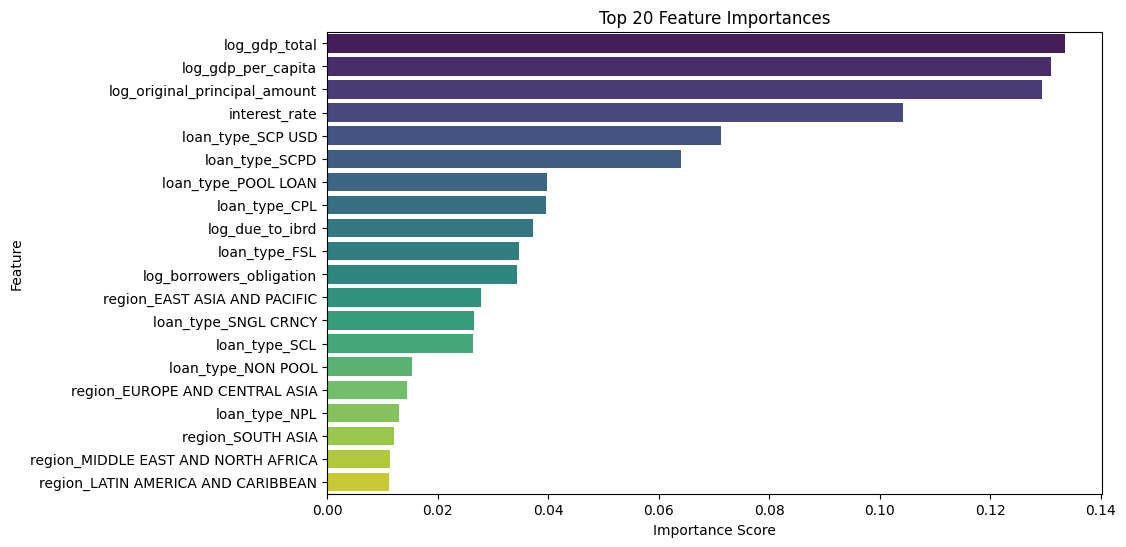

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(20), y=importances.head(20).index, palette="viridis")
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


# 📊 Model Predictions Visualization


In [ ]:
# Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("CatBoost Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# Feature Importance (Top 15)
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10,8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Actual vs Predicted Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
y_test_counts = pd.Series(y_test).value_counts().sort_index()
plt.bar(le.classes_, y_test_counts.values, alpha=0.7, color='steelblue')
plt.title('Actual Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=11)
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
y_pred_counts = pd.Series(y_pred.flatten()).value_counts().sort_index()
plt.bar(le.classes_, y_pred_counts.values, alpha=0.7, color='darkgreen')
plt.title('Predicted Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=11)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"✅ Model evaluation visualizations complete!")


In [26]:
import pandas as pd

# Get feature importances and sort them descending
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print top 30 for clarity
print("=== Top 30 Most Important Features ===\n")
for feature, importance in importances.head(30).items():
    print(f"{feature:40s} {importance:.4f}")

# Print bottom 10 (least important)
print("\n=== 10 Least Important Features ===\n")
for feature, importance in importances.tail(10).items():
    print(f"{feature:40s} {importance:.4f}")


=== Top 30 Most Important Features ===

log_gdp_total                            0.1335
log_gdp_per_capita                       0.1310
log_original_principal_amount            0.1293
interest_rate                            0.1043
loan_type_SCP USD                        0.0713
loan_type_SCPD                           0.0640
loan_type_POOL LOAN                      0.0398
loan_type_CPL                            0.0395
log_due_to_ibrd                          0.0372
loan_type_FSL                            0.0347
log_borrowers_obligation                 0.0343
region_EAST ASIA AND PACIFIC             0.0278
loan_type_SNGL CRNCY                     0.0265
loan_type_SCL                            0.0264
loan_type_NON POOL                       0.0154
region_EUROPE AND CENTRAL ASIA           0.0144
loan_type_NPL                            0.0131
region_SOUTH ASIA                        0.0122
region_MIDDLE EAST AND NORTH AFRICA      0.0114
region_LATIN AMERICA AND CARIBBEAN       0.0113


In [28]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
import time

# ============================
# 1️⃣ Define categorical + numerical columns
# ============================
cat_cols = ["loan_type", "region"]
num_cols = [
    "interest_rate",
    "log_original_principal_amount",
    "log_borrowers_obligation",
    "log_due_to_ibrd",
    "log_gdp_total",
    "log_gdp_per_capita"
]

X = df_clean[cat_cols + num_cols]
y = df_clean["loan_outcome_encoded"]

# Drop missing rows
df_model = df_clean.dropna(subset=cat_cols + num_cols + ["loan_outcome_encoded"])
X = df_model[cat_cols + num_cols]
y = df_model["loan_outcome_encoded"]

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# CatBoost requires column indices (not names)
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

# ============================
# 2️⃣ Build datasets
# ============================
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_idx)

# ============================
# 3️⃣ Train CatBoost
# ============================
model = CatBoostClassifier(
    iterations=500,              # total max trees
    depth=8,
    learning_rate=0.05,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    random_seed=42,
    od_type="Iter",              # ✅ early stopping
    od_wait=40,                  # stop if no improvement for 40 rounds
    verbose=50                   # ✅ prints progress every 50 iters
)

print("\n⏳ Training CatBoost on CPU...")
start = time.time()
model.fit(train_pool, eval_set=test_pool)
end = time.time()
print(f"\n✅ Training finished in {round(end - start, 2)} seconds")

# ============================
# 4️⃣ Evaluate
# ============================
y_pred = model.predict(test_pool)
y_pred = y_pred.flatten()  # converts (N,1) → (N,)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



⏳ Training CatBoost on CPU...
0:	learn: 1.0716052	test: 1.0718618	best: 1.0718618 (0)	total: 229ms	remaining: 1m 54s
50:	learn: 0.6462076	test: 0.6493215	best: 0.6493215 (50)	total: 9.26s	remaining: 1m 21s
100:	learn: 0.5196802	test: 0.5223880	best: 0.5223880 (100)	total: 18.1s	remaining: 1m 11s
150:	learn: 0.4342951	test: 0.4365986	best: 0.4365986 (150)	total: 29s	remaining: 1m 7s
200:	learn: 0.3768200	test: 0.3791833	best: 0.3791833 (200)	total: 39.8s	remaining: 59.2s
250:	learn: 0.3309671	test: 0.3331686	best: 0.3331686 (250)	total: 50.2s	remaining: 49.8s
300:	learn: 0.2916371	test: 0.2935439	best: 0.2935439 (300)	total: 1m	remaining: 40.2s
350:	learn: 0.2592628	test: 0.2613174	best: 0.2613174 (350)	total: 1m 9s	remaining: 29.6s
400:	learn: 0.2343364	test: 0.2363257	best: 0.2363257 (400)	total: 1m 17s	remaining: 19.1s
450:	learn: 0.2108697	test: 0.2127710	best: 0.2127710 (450)	total: 1m 23s	remaining: 9.03s
499:	learn: 0.1914051	test: 0.1932974	best: 0.1932974 (499)	total: 1m 28s	r

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [30]:
df_model[feature_cols + ["loan_outcome_encoded"]].corr()["loan_outcome_encoded"].sort_values(ascending=False)


loan_outcome_encoded             1.000000
log_original_principal_amount    0.033248
interest_rate                    0.025478
log_gdp_total                   -0.055975
log_borrowers_obligation        -0.082978
log_due_to_ibrd                 -0.084012
log_gdp_per_capita              -0.085237
Name: loan_outcome_encoded, dtype: float64

In [37]:
from catboost import cv, Pool
from sklearn.model_selection import StratifiedKFold

cat_cols = ["region"]
num_cols = [
    "interest_rate",
    "log_original_principal_amount",
    "log_gdp_total",
    "log_gdp_per_capita"
]

df_model = df_clean.dropna(subset=cat_cols + num_cols + ["loan_outcome_encoded"])
X = df_model[cat_cols + num_cols]
y = df_model["loan_outcome_encoded"]

cat_idx = [X.columns.get_loc(c) for c in cat_cols]

pool = Pool(X, y, cat_features=cat_idx)

params = {
    "loss_function": "MultiClass",
    "eval_metric": "Accuracy",
    "depth": 8,
    "learning_rate": 0.05,
    "iterations": 500,
    "random_seed": 42,
    "verbose": False
}

cv_results = cv(
    params=params,
    pool=pool,
    fold_count=5,
    shuffle=True,
    stratified=True,
    verbose=False
)

print("Mean CV Accuracy:", cv_results["test-Accuracy-mean"].iloc[-1])
print("Std Dev:", cv_results["test-Accuracy-std"].iloc[-1])



Training on fold [0/5]

bestTest = 0.959697733
bestIteration = 498

Training on fold [1/5]

bestTest = 0.9622945286
bestIteration = 484

Training on fold [2/5]

bestTest = 0.9623974239
bestIteration = 495

Training on fold [3/5]

bestTest = 0.9609431806
bestIteration = 494

Training on fold [4/5]

bestTest = 0.9616173683
bestIteration = 485

Mean CV Accuracy: 0.9613848532828226
Std Dev: 0.0011069948844540589
